<h3>Analize Marketing Campaign Effectiveness using ML Classification (KNN,LR,DT,SVC) </h3>

<p>The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).</p>

<h4>Problem Definition</h4>

<p>The ultimate goal of this analysis is to understand the key variables and create a predictive model to forecast the success of direct marketing campaigns by encouraging customers to subscribe to a term deposit.</p>



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree



<h3> Data Collection</h3>
<p> The data for this excersice comes from the University of California </p>

In [2]:
# Install the University of California Irvine reporsitory to extract the rata
!pip install ucimlrepo

In [10]:
# Pulls the data for this excercise
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
# To simplify clasification as the target varaible is categorical, I map it to numerical.
y= y['y'].map({"yes": 1, "no": 0})
# This allow us to understand what data is numeric or categorical.
X.dtypes

age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
dtype: object

<h3>Exploratory Data Analysis</h3>

<p>After performing this analysis, it can be seen that the population has an average success rate of 12%. From this data, it is evident that October, September, March, and December are the months when people are more likely to subscribe to a term deposit. Additionally, retired and students have a higher success rate, and likewise, the higher the education level, the more likely they are to join.</p>


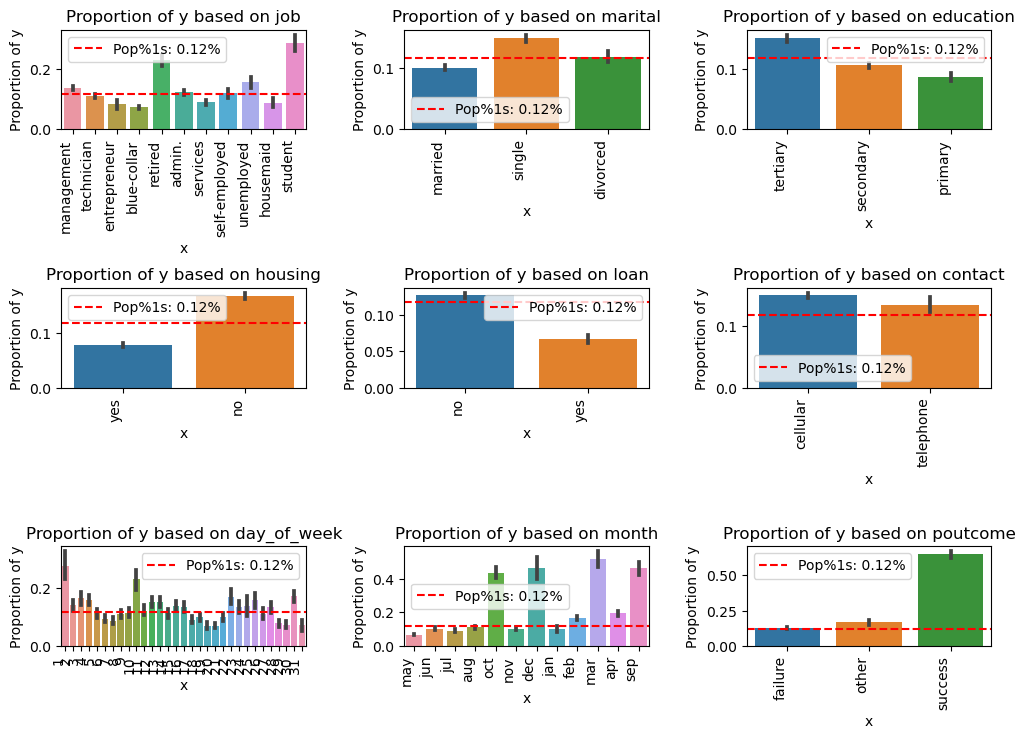

In [84]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.subplots_adjust(hspace=1.6, wspace=0.4)  # Increase vertical and horizontal space
percentage_of_ones = (y.sum() / y.count()) 

for i, feature in enumerate(categorical_features):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    sns.barplot(x=X[feature], y=y, ax=ax)  # ci=None suppresses the confidence intervals
    ax.set_xlabel('x')
    ax.set_ylabel('Proportion of y')
    ax.set_title(f'Proportion of y based on {feature}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")  # Rotate 90 degrees

    # Add a line indicating the percentage of '1' values
    ax.axhline(y=percentage_of_ones, color='red', linestyle='--', label=f'Pop%1s: {percentage_of_ones:.2f}%')

    # Display the legend
    ax.legend()

plt.show()

<h3>Correlation Matrix</h3>

<p>The following matrix shows the correlation of each of the numerical variables. It can be observed that there is weak correlation among them, indicating that multicollinearity issues should not be a concern.</p>


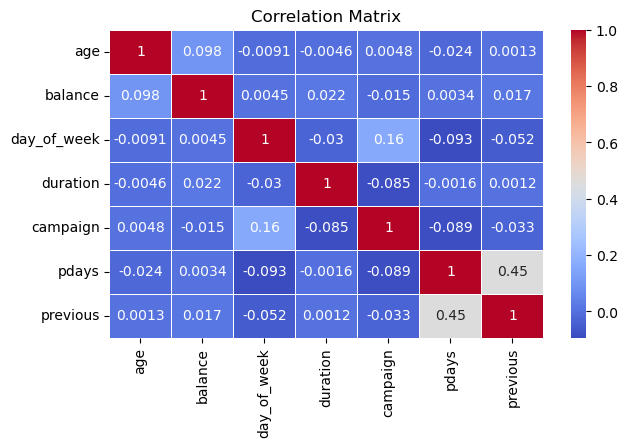

In [72]:
correlation_matrix = X.corr(numeric_only=True)
plt.figure(figsize=(7, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

<h3>Data Preparation</h3>

<p>For this step, I am separating data into test and train sets, as well as imputing missing data if necessary, scaling, and encoding.</p>


In [11]:
# Split the data into test and train set to evaluate model performance later on
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
3344,41,blue-collar,married,primary,no,849,yes,no,NaN,15,may,72,1,-1,0,NaN
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0,NaN
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0,NaN
10221,37,management,single,tertiary,no,-119,yes,no,NaN,11,jun,375,11,-1,0,NaN
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,NaN,18,jun,2093,1,-1,0,NaN
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,92,1,failure
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0,NaN
860,33,retired,married,secondary,no,165,no,no,NaN,7,may,111,1,-1,0,NaN


<h3>Feature Engineering</h3>

<p>Features are categorized into categorical and numerical. Simple imputers are put in place to fill missing data, encoders are used to transform categorical data into numerical data, and standard scalers are applied to normalize numerical variables.</p>


In [12]:
# Define which columns are numeric and categorical to define how transformers will work
numeric_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous','day_of_week']
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact',  'month', 'poutcome']


In [13]:
# For numerical data, if data is missing we will use Simple Imputer using a median strategy, then use standard scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical data we will use Simple Imputer with most frequent and the use One Hot Encoder. 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [14]:
# This preprocesor is used inside the main pipeline call for the required transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

<h3>Model Selection and Hyperparameters to Test</h3>

<p>In the section below, I define the models we would like to evaluate, as well as the hyperparameters to test using Grid Search CV.</p>


In [15]:
# This object contains the hyperparameters to be evaluated for each of the models, as well as the 
# model name that will be used to iterate for each of the models  
hyperparameters = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7,10,15,20,30,100],
            'model__weights': ['uniform', 'distance']
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'model__max_depth': [None, 5, 10, 20]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'model__C': [0.01, 0.1, 1.0]
        }
    },
    'SVC': {
        'model': SVC(),
        'params': {
            'model__C': [0.01, 0.1, 1.0],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

results = {}

<h3>Model, Training, Evaluation</h3>

<p>In this section, the algorithm iterates over each of the models and stores the results in a results object. In each iteration, a pipeline is defined. The pipeline performs the preprocessing steps first and then calls the model. A Grid Search CV with 5-fold cross-validation is performed to optimize for accuracy and define the best hyperparameters. Once the ideal grid model is found, a prediction for the test data is executed, and the results are stored.</p>

    

In [16]:
# Iterate through models and hyperparameters
for model_name, config in hyperparameters.items():
    model = config['model']
    params = config['params']

    # Create a pipeline for the current model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Perform grid search cross-validation, n_jobs uses all available CPUs to speed up the firring process. 
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Make predictions
    y_pred = grid.predict(X_test)

    # Store results
    results[model_name] = {
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    if model_name == 'DecisionTree':
        Tree=grid
    elif model_name == 'SVC':
        Svc=grid
    elif model_name == 'KNN':
        Knn=grid
    elif model_name == 'LogisticRegression':
        Lr=grid    
        
        
   

<h3> Model Interpretation </h3>
<p> The idea from this point forward is to visualize and interpret the results of the different models </p>

<h3>Visualizing Decision Tree</h3>

<p>The ideal depth of the decision tree is 5, making it somewhat complex to visualize. However, below, you can see the decisions made at each of the nodes. The first decision is based on the duration, followed by an examination of the previous outcome, marital status, age, and balance.</p>


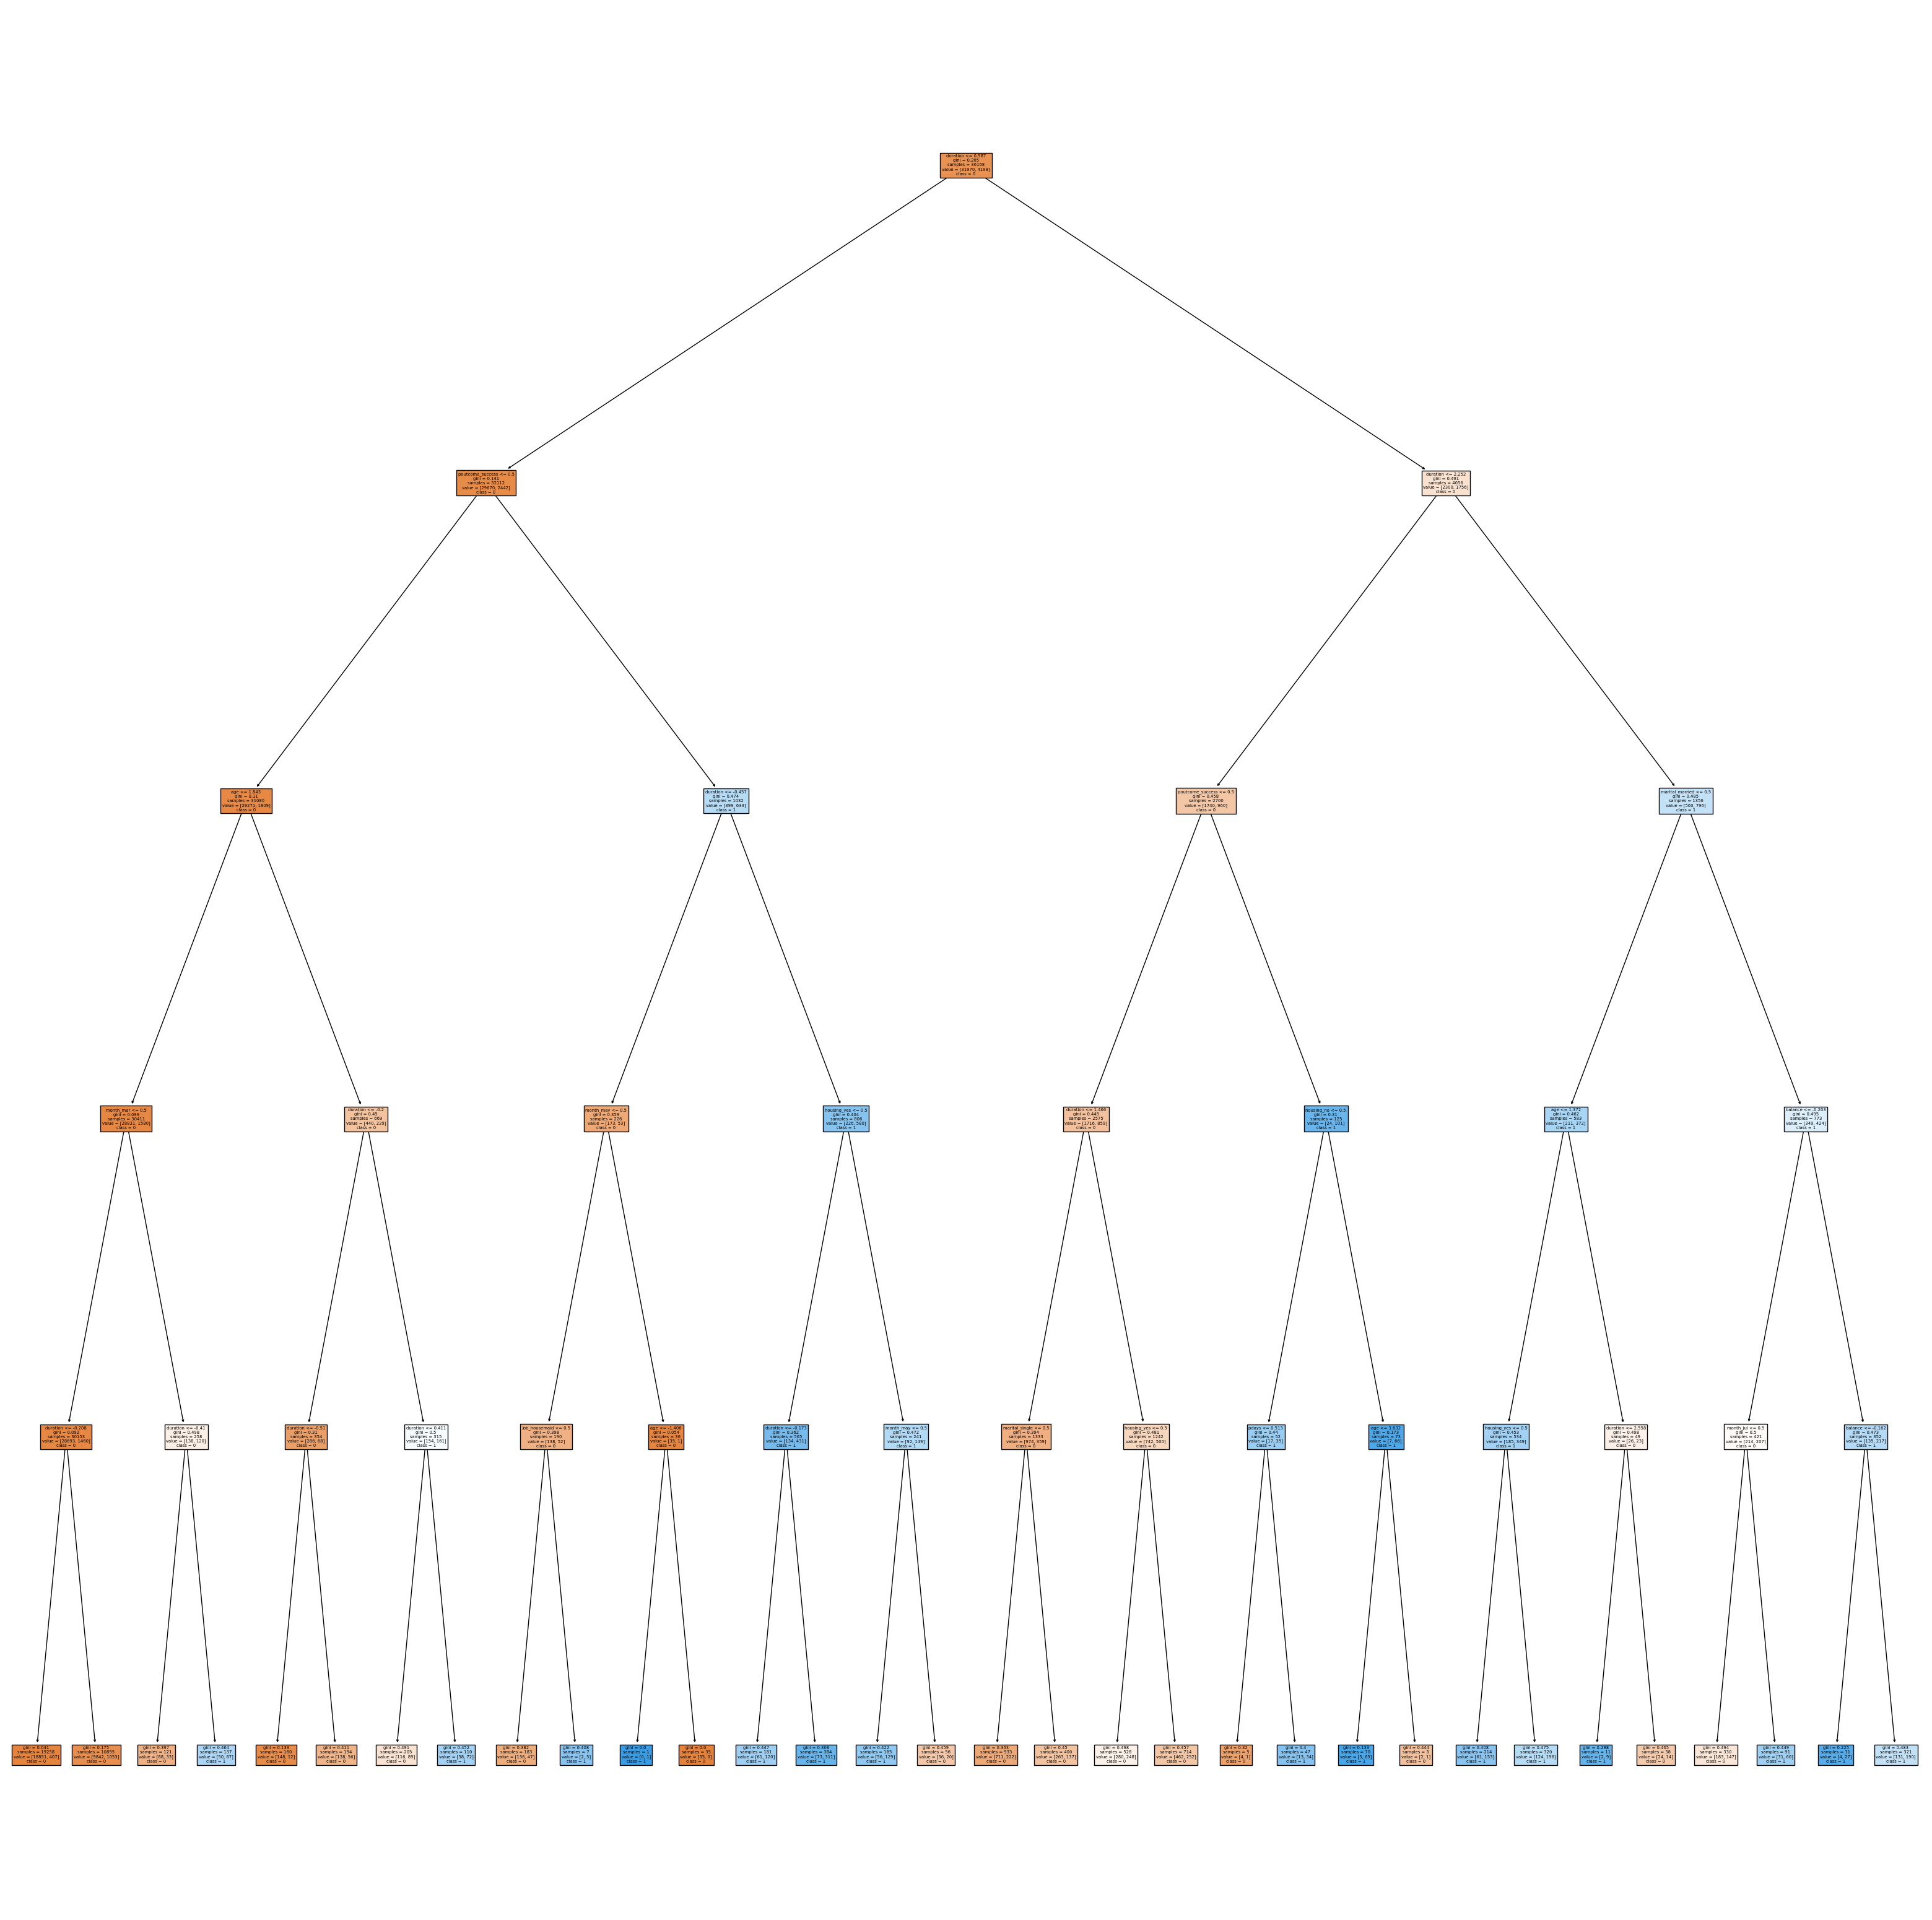

In [17]:
visualizations = {}
categorical=Tree.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
numerical=Tree.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
all_features=list(numerical)+list(categorical)


plt.figure(figsize=(40, 40))
plot_tree(Tree.best_estimator_.named_steps['model'], filled=True, feature_names=all_features, class_names=['0', '1'])
visualizations['DecisionTree'] = plt

<h3>Visualizing Logistic Regression</h3>

<p>In line with the weight given on the decision trees, the duration of the call appears to have significant importance. Additionally, the month variable is interesting. It's worth noting that the decision tree may not assign the same weight to the month, as in this case, March might be considered an outlier with fewer samples. However, the duration is a continuous variable that all customers experience. Given this, it appears that duration is a key factor in defining the success of the campaign.</p>


In [18]:
# Fit the Logistic Regression model on the entire training dataset
logistic_regression_model = Lr.best_estimator_.named_steps['model']

categorical=Lr.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
numerical=Lr.best_estimator_.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
Lr_all_features=list(numerical)+list(categorical)

#logistic_regression_model.fit(X_train, y_train)

# Retrieve the coefficients for each feature
coefficients = logistic_regression_model.coef_[0]

coefficients_df = pd.DataFrame({'Feature': Lr_all_features, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df



,Feature,Coefficient
37,month_mar,1.640665
44,poutcome_success,1.493025
2,duration,1.056034
40,month_oct,0.913468
41,month_sep,0.866410
32,month_dec,0.675157
15,job_student,0.524766
24,housing_no,0.379656
12,job_retired,0.367284
26,loan_no,0.215546


<h3>Results</h3>

<p>The following sections iterate over the results object and print the model name, parameters, accuracy, the classification report to identify precision, accuracy, and the confusion matrix.</p>

<p>It is interesting to note that the accuracy of all the models, as well as the confusion matrices, looks very similar. The only model that was able to achieve a slightly better result was the SVC model; the rest


Model: KNN
Best Parameters: {'model__n_neighbors': 30, 'model__weights': 'distance'}
Accuracy: 0.8983744332632976
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.69      0.29      0.41      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.63      0.68      9043
weighted avg       0.88      0.90      0.88      9043



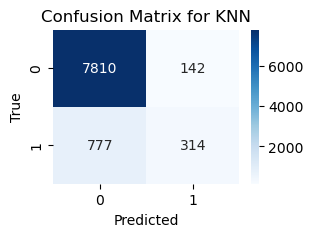



Model: DecisionTree
Best Parameters: {'model__max_depth': 5}
Accuracy: 0.8978215194072764
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7952
           1       0.65      0.33      0.44      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.88      9043



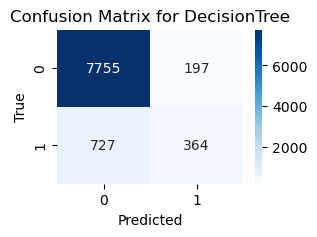



Model: LogisticRegression
Best Parameters: {'model__C': 1.0}
Accuracy: 0.8989273471193188
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.94      7952
           1       0.65      0.34      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.88      0.90      0.88      9043



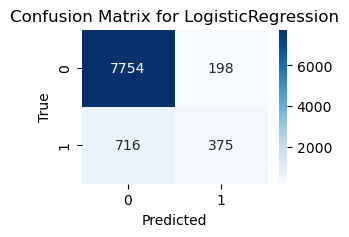



Model: SVC
Best Parameters: {'model__C': 1.0, 'model__kernel': 'rbf'}
Accuracy: 0.9004755059161783
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      7952
           1       0.68      0.34      0.45      1091

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



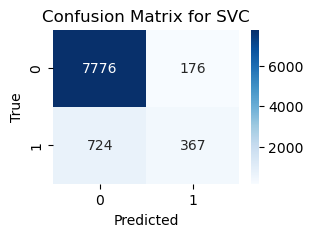

In [51]:
for model_name, result in results.items():
    print(f'Model: {model_name}')
    print(f'Best Parameters: {result["best_params"]}')
    print(f'Accuracy: {result["accuracy"]}')
    print(f'Classification Report:\n{result["classification_report"]}')
    
    # Print the confusion matrix as a heatmap
    plt.figure(figsize=(3, 2))  # Set the figure size as needed
    sns.heatmap(result["confusion_matrix"], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print('\n')

<h3>Understanding PCA</h3>

<p>This is not part of this activity, but I was looking to see if, by reducing dimensions using PCA, I was able to identify common behavior that would allow us to predict success in a simple way.</p>

<p>I also tried to see how unsupervised clustering would perform in terms of classifying success, comparing it to a confusion matrix. It was a bit of a stretch, but I was just wanting to understand if there was any relationship.</p>



C:\Users\fcely\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


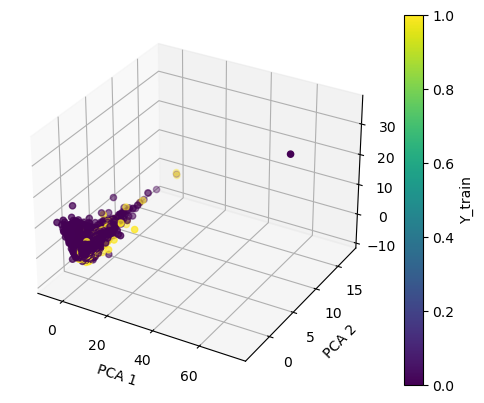

Confusion Matrix:
[[27517  4453]
 [ 2957  1241]]


In [41]:
# Fit and transform the preprocessor on the training data
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

X_train_preprocessed = preprocessor.transform(X_train)

# Perform PCA to reduce dimensionality to 3 principal components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_preprocessed)

# Use K-Means clustering to group data points into clusters
kmeans = KMeans(n_clusters=2, random_state=42)  # Assuming 2 clusters for binary classification
kmeans.fit(X_pca)
y_kmeans = kmeans.predict(X_pca)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points with colors based on y_train
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap='viridis')

# Set labels for the axes
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')

# Add a colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_label('Y_train')

#plt.title
plt.show()


# Comparing Unsupervised Clustering to Supervised Clustering
conf_matrix = confusion_matrix(y_train, y_kmeans)
print("Confusion Matrix:")
print(conf_matrix)